CONFIRM CASES


In [ ]:
pip install helper

In [4]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [5]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [6]:
q=dataframe.query('Country=="Iran"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     120198
2020-05-18     122492
2020-05-19     124603
2020-05-20     126949
2020-05-21     129341

[121 rows x 1 columns]

In [7]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28      92584
2020-04-29      93657
2020-04-30      94640
2020-05-01      95646
2020-05-02      96448
2020-05-03      97424
2020-05-04      98647
2020-05-05      99970
2020-05-06     101650
2020-05-07     103135
2020-05-08     104691
2020-05-09     106220
2020-05-10     107603
2020-05-11     109286
2020-05-12     110767
2020-05-13     112725
2020-05-14     114533
2020-05-15     116635
2020-05-16     118392
2020-05-17     120198
2020-05-18     122492
2020-05-19     124603
2020-05-20     126949
2020-05-21     129341

In [8]:
# Seriies to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


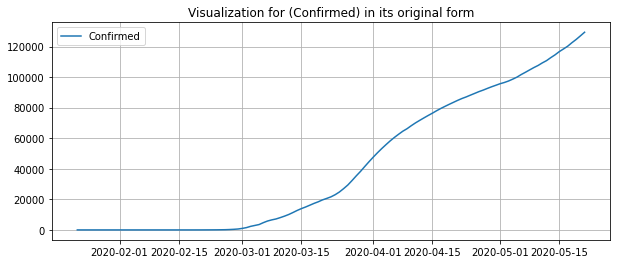

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [10]:
df.tail()

Confirmed
Date                 
2020-05-17     120198
2020-05-18     122492
2020-05-19     124603
2020-05-20     126949
2020-05-21     129341

In [11]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [12]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     120198
2020-05-18     122492
2020-05-19     124603
2020-05-20     126949
2020-05-21     129341

In [13]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [14]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [15]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [17]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [18]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [19]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 60759.88480448713, 42155.00826446281)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 60759.88480448713, 42155.00826446281)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 43589.36291875498, 39746.43084488765)
([(0, 0, 0), (0, 0, 0, 365), 't'], 19959.237373574608, 17398.037847549942)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 13123.542713520652, 11063.788025296906)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 30524.156729074664, 21242.13050812524)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 23470.962255637594, 20160.012147135923)
([(0, 0, 1), (0, 0, 0, 365), 't'], 10079.176856365748, 8623.691583839147)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 24177.08873138209, 20536.115117748377)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 15850.161866260212, 11063.363391057484)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 31609.181546448723, 20689.26657372628)
([(0, 0, 2), (0, 0, 0, 365), 't'], 5248.508561789224, 4570.503663726731)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 8006.4928512827455, 6355.353902677117)
([(0, 1, 0), (0, 0, 0, 36

In [20]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 1, 2), (0, 0, 0, 365), 't'] 171.2157720866297 117.03448306628435


In [21]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

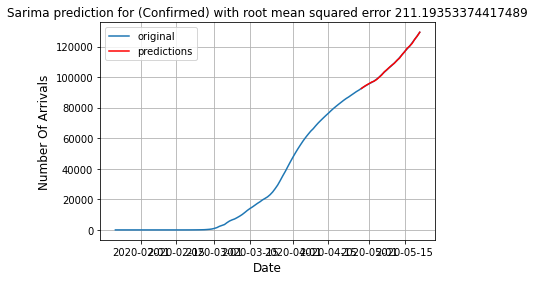

In [22]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [23]:
errors = mape(test, predictions)
errors

11.745631801503203

In [ ]:
#Recovered Cases in Iran'''

RECOVERED CASES

In [24]:
q=dataframe.query('Country=="Iran"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      94464
2020-05-18      95661
2020-05-19      97173
2020-05-20      98808
2020-05-21     100564

[121 rows x 1 columns]

**Spliting the dataset**

In [25]:
trainr=dfr[0:97]
testr=dfr[97:]
len(testr)

24

In [26]:
# Seriies to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


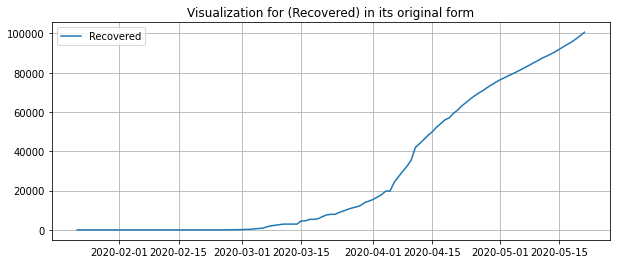

In [27]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [28]:
dfr.tail()

Recovered
Date                 
2020-05-17      94464
2020-05-18      95661
2020-05-19      97173
2020-05-20      98808
2020-05-21     100564

In [29]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [30]:
df_to_test.tail()

Recovered
Date                 
2020-05-17      94464
2020-05-18      95661
2020-05-19      97173
2020-05-20      98808
2020-05-21     100564

In [31]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [32]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [33]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [34]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [35]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 44821.940313545936, 28462.495867768594)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 44821.940313545936, 28462.495867768594)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 34528.21321966077, 30806.95758486442)
([(0, 0, 0), (0, 0, 0, 365), 't'], 19348.557944074106, 17306.1639728099)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 14245.545747664824, 12593.355618636755)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 22620.032451002065, 14385.890975167646)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 69437.11600025398, 44478.308329329244)
([(0, 0, 1), (0, 0, 0, 365), 't'], 20365.766329077513, 18264.158857416172)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 27441.969065667785, 24495.55225892339)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 13073.481213629622, 8272.073392080012)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 21549.381656012818, 14666.080097587932)
([(0, 0, 2), (0, 0, 0, 365), 't'], 22147.52308655477, 20248.7520628366)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 9970.950801098379, 8045.230808841034)
([(0, 1, 0), (0, 0, 0, 3

In [38]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 1, 2), (0, 0, 0, 365), 't'] 585.7730987411559 309.0697601452759


In [39]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

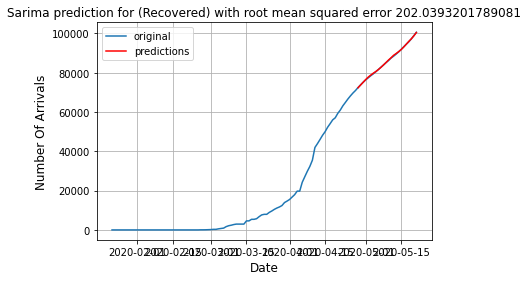

In [40]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [41]:
mape(testr, predictions)

10.968680801322606

In [42]:
# Deaths cases

DEATH CASES

In [43]:
q=dataframe.query('Country=="Iran"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17    6988
2020-05-18    7057
2020-05-19    7119
2020-05-20    7183
2020-05-21    7249

[121 rows x 1 columns]

In [45]:
# Series to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


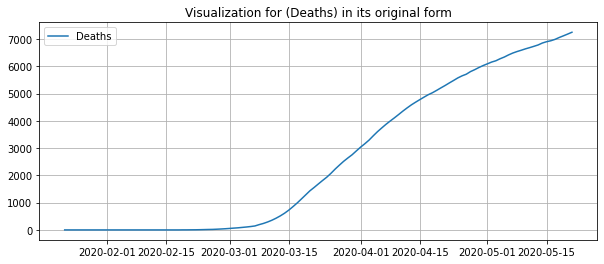

In [46]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [47]:
dfd.tail()

Deaths
Date              
2020-05-17    6988
2020-05-18    7057
2020-05-19    7119
2020-05-20    7183
2020-05-21    7249

In [48]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28    5877
2020-04-29    5957
2020-04-30    6028
2020-05-01    6091
2020-05-02    6156
2020-05-03    6203
2020-05-04    6277
2020-05-05    6340
2020-05-06    6418
2020-05-07    6486
2020-05-08    6541
2020-05-09    6589
2020-05-10    6640
2020-05-11    6685
2020-05-12    6733
2020-05-13    6783
2020-05-14    6854
2020-05-15    6902
2020-05-16    6937
2020-05-17    6988
2020-05-18    7057
2020-05-19    7119
2020-05-20    7183
2020-05-21    7249

In [49]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [50]:
df_to_test.tail()

Deaths
Date              
2020-05-17    6988
2020-05-18    7057
2020-05-19    7119
2020-05-20    7183
2020-05-21    7249

In [51]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [52]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [53]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [54]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [55]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 3740.563024973868, 2610.9504132231405)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 3740.563024973868, 2610.9504132231405)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 2668.034918740989, 2438.879379823782)
([(0, 0, 0), (0, 0, 0, 365), 't'], 1206.0658015813424, 1050.1207811794607)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 794.2883650506111, 662.1601723353187)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 1904.359177859144, 1334.1726661860278)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 1378.2183568399787, 1256.8410496704155)
([(0, 0, 1), (0, 0, 0, 365), 't'], 611.7458142470541, 534.0708509558134)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 440.536541195464, 350.0039338985961)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 4372.920623435718, 3034.9002263589737)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 765.6648451767956, 676.128169111703)
([(0, 0, 2), (0, 0, 0, 365), 't'], 316.44728597715346, 277.32748317915474)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 307.69576609792256, 203.96779964924903)
([(0, 1, 0), (0, 0, 0, 365), 'n

In [57]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 0, 2), (0, 0, 0, 365), 'ct'] 9.703515657192332 7.244883733835112


In [58]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

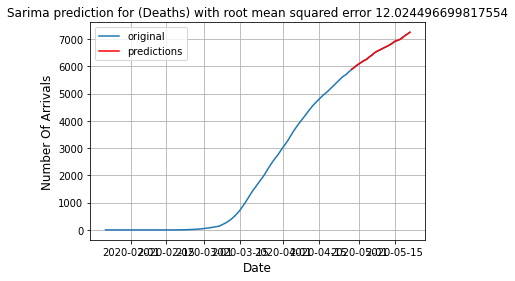

In [59]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [60]:
mape(testd,predictions)

7.007148382815963